In [1]:
%matplotlib notebook
import pystan
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import scipy.stats
import pandas as pd
from brasileirao2015 import brasileirao
import random

In [2]:
cols = ['data', 'hora', 'time_casa', 'time_fora', 'gols_casa', 'gols_fora']
df = pd.DataFrame(columns=cols)
for jogo in brasileirao:
    gols_casa = jogo[10].split(' : ')[0]
    gols_fora = jogo[10].split(' : ')[1]
    df.loc[len(df)] = [jogo[2], jogo[3], jogo[5], jogo[8], gols_casa, gols_fora]

In [3]:
print('Jogos ganhos em casa:', len(df[df.gols_casa > df.gols_fora]))
print('Jogos ganhos fora de casa:', len(df[df.gols_casa < df.gols_fora]))

Jogos ganhos em casa: 200
Jogos ganhos fora de casa: 89


In [4]:
set(df.time_casa) | set(df.time_fora)

{'Atletico MG',
 'Atletico PR',
 'Avai FC',
 'Chapecoense AF',
 'Corinthians',
 'Coritiba',
 'Cruzeiro',
 'Figueirense',
 'Flamengo',
 'Fluminense',
 'Goias',
 'Gremio',
 'Internacional',
 'Joinville',
 'Palmeiras',
 'Ponte Preta',
 'Santos FC',
 'Sao Paulo',
 'Sport',
 'Vasco da Gama'}

In [5]:
team_idx = {team: i for i, team in enumerate(set(df.time_casa) | set(df.time_fora), start=1)}
idx_team = {idx: team for team, idx in team_idx.items()}

In [6]:
matches = []
for _, row in df.iterrows():
    time_casa = row[2]
    time_fora = row[3]
    gols_casa = row[4]
    gols_fora = row[5]
    matches.append([team_idx[time_casa], team_idx[time_fora], gols_casa, gols_fora])
matches = np.array(matches, dtype=np.int64)

## model

In [7]:
code = '''
data {
    int n_matches;
    int n_teams;
    int matches[n_matches, 4]; // time_casa, time_fora, gols_casa, gols_fora
}
parameters {
    real C[n_teams]; // casa-fora
    real B[n_teams]; // bias
    real A[n_teams]; // ataque
    real D[n_teams]; // defesa
}
transformed parameters {
    real LAMBDA[n_teams]; // poisson models
    for(i in 1:n_matches){
        LAMBDA[matches[i, 1]] <- exp(C[matches[i, 1]]*1 + A[matches[i, 1]] - D[matches[i, 2]] + B[matches[i, 1]]);
        LAMBDA[matches[i, 2]] <- exp(C[matches[i, 2]]*0 + A[matches[i, 2]] - D[matches[i, 1]] + B[matches[i, 2]]);
    }
}
model {
    C ~ normal(0, 1); 
    B ~ normal(0, 1); 
    A ~ normal(0, 1); 
    D ~ normal(0, 1); 
    
    for(i in 1:n_matches){
        matches[i, 3] ~ poisson(LAMBDA[matches[i, 1]]);
        matches[i, 4] ~ poisson(LAMBDA[matches[i, 2]]);
    }
}
'''
    
data = {
    'n_matches': len(matches),
    'n_teams': len(set(matches[:,0]) | set(matches[:,1])),
    'matches': matches,
}
fit = pystan.stan(model_code=code, data=data, iter=1000, chains=4)

/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit object

In [8]:
print(fit)

Inference for Stan model: anon_model_6f619545c6b1e7f5c471da69da43b6cf.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C[0]        -0.02    0.02   1.01  -1.95   -0.7  -0.04   0.67   2.05   2000    1.0
C[1]       5.5e-3    0.02   1.04  -2.01  -0.72-9.9e-3   0.71   2.08   2000    1.0
C[2]         0.02    0.02   0.95  -1.87  -0.61   0.03   0.67   1.92   2000    1.0
C[3]         0.03    0.02   0.87  -1.62   -0.6   0.04   0.63    1.7   2000    1.0
C[4]         -0.1    0.02    0.9  -1.87   -0.7   -0.1   0.52   1.68   2000    1.0
C[5]        -0.04    0.02   0.85   -1.7  -0.61  -0.03   0.51    1.7   2000    1.0
C[6]         0.16    0.02   0.87  -1.55  -0.43   0.15   0.75   1.83   2000    1.0
C[7]      -6.3e-3    0.02   1.01  -1.99   -0.7  -0.03   0.67    2.0   2000    1.0
C[8]         0.02    0.02   0.87  -1.68  -0.57   0.03   0.61   1.76   2000 

In [9]:
trace = fit.extract()

In [27]:
idx_team

{1: 'Atletico PR',
 2: 'Cruzeiro',
 3: 'Avai FC',
 4: 'Flamengo',
 5: 'Joinville',
 6: 'Coritiba',
 7: 'Atletico MG',
 8: 'Fluminense',
 9: 'Internacional',
 10: 'Gremio',
 11: 'Chapecoense AF',
 12: 'Sport',
 13: 'Vasco da Gama',
 14: 'Goias',
 15: 'Ponte Preta',
 16: 'Figueirense',
 17: 'Sao Paulo',
 18: 'Santos FC',
 19: 'Corinthians',
 20: 'Palmeiras'}

<IPython.core.display.Javascript object>


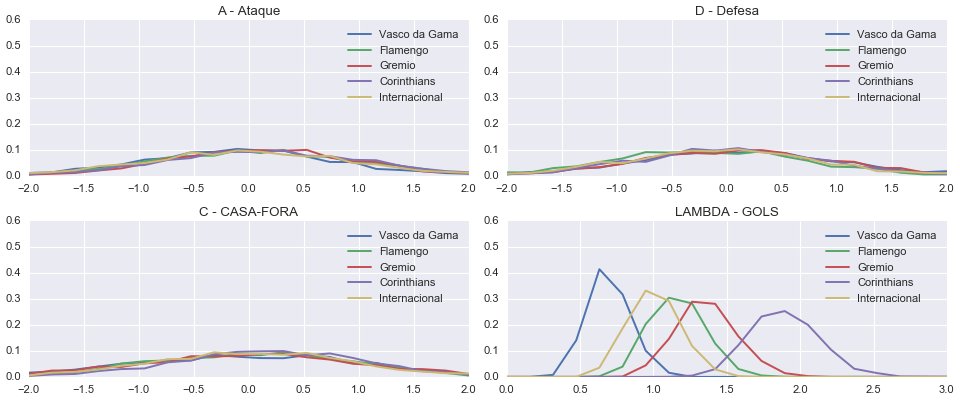

In [56]:
teams_to_plot = [13, 4, 10, 19, 9]
ylim = [0, 0.6]
plt.figure(figsize=(12,5))

for i in teams_to_plot:
    plt.subplot(2,2,1)
    plt.title('A - Ataque')
    hist, vals = np.histogram(trace['A'][:, i-1], range=[-2, 2], bins=20)
    plt.plot(np.linspace(-2, 2, len(hist)), hist/hist.sum(), label=idx_team[i])
    plt.ylim(ylim)
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.title('D - Defesa')
    hist, vals = np.histogram(trace['D'][:, i-1], range=[-2, 2], bins=20)
    plt.plot(np.linspace(-2, 2, len(hist)), hist/hist.sum(), label=idx_team[i])
    plt.ylim(ylim)
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.title('C - CASA-FORA')
    hist, vals = np.histogram(trace['C'][:, i-1], range=[-2, 2], bins=20)
    plt.plot(np.linspace(-2, 2, len(hist)), hist/hist.sum(), label=idx_team[i])
    plt.ylim(ylim)
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.title('LAMBDA - GOLS')
    hist, vals = np.histogram(trace['LAMBDA'][:, i-1], range=[0, 3], bins=20)
    plt.plot(np.linspace(0, 3, len(hist)), hist/hist.sum(), label=idx_team[i])
    plt.ylim(ylim)
    plt.legend()
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)